Plot Example Sign Map, Phase Contours, and Magnitude Heatmap for each Rearing Condition

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from tifffile import imread
from skimage import filters
from os.path import exists

class Cursor:
    '''Define crosshair cursor (from matplotlib documentation).'''
    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()
            
def mask_array(array, mask_idx):
    np.add.at(array, mask_idx, np.nan)
    row_mask = np.where(~np.isnan(array).all(axis=1))[0]
    row_nan = np.where(np.isnan(array).all(axis=1))[0]
    n_row = sum(row_nan < array.shape[0]/2)
    col_mask = np.where(~np.isnan(array).all(axis=0))[0]
    col_nan = np.where(np.isnan(array).all(axis=0))[0]
    n_col = sum(col_nan < array.shape[1]/2)
    edge_mask = np.ix_(row_mask, col_mask)
    return array[edge_mask], (n_row, n_col)

def draw_colorbar(mappable, cax, label="", num_ticks=6, width="5%", height="100%", loc="center left", frmt="%i", ori="vertical", label_pos="left", ticks="left"):
    cax = inset_axes(cax, width=width, height=height, loc=loc, borderpad=-3)
    colorbar = fig.colorbar(mappable, cax=cax, orientation=ori)
    colorbar.set_label(label, color='k', fontsize=20)
    colorbar.ax.locator_params(nbins=num_ticks)
    if ori == "vertical":
        if ticks == "left":
            cax.yaxis.tick_left()
            cax.yaxis.set_label_position(label_pos)
        else:
            cax.yaxis.tick_right()
            cax.yaxis.set_label_position(label_pos)
            cax.yaxis.label.set_rotation(-90)
        cax.yaxis.set_major_formatter(FormatStrFormatter(frmt))
    elif ori == "horizontal":
        cax.xaxis.tick_top()
        cax.xaxis.set_label_position(label_pos)
        cax.xaxis.set_major_formatter(FormatStrFormatter(frmt))
    cax.tick_params(labelsize=20)
    return colorbar

exp_path = "G:/Shared drives/Mapping through skull/"
examples = ["NR_ctb03/", 
            "DR_ctb01/"]
mask_idx = {}
for ex in examples:
    signmap = np.loadtxt(exp_path + ex + "signmap.csv")
    # Plot reference frame and get user input for center and edge points of circular mask
    %matplotlib qt5
    fig, ax = plt.subplots()
    ax.imshow(signmap, cmap="RdBu_r", alpha=0.6, clim=[-1, 1])
    ax.axis('off')
    ax.set_title('Select Center Point and Edge Point for Circular Mask:', fontsize=20, color='k')
    fig.set_size_inches(10, 10)
    cursor = Cursor(ax)
    fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
    mask_coors = plt.ginput(n=2, timeout=-1)
    # Generate mask and get indices to set as nan
    import cv2
    ref_frame = imread(exp_path + ex + "refframe.tif").squeeze()
    mask = np.zeros(ref_frame.shape, dtype=np.uint8)
    radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))
    circle = cv2.circle(mask, (int(mask_coors[0][0]),int(mask_coors[0][1])), int(radius), (255,255,255), -1).astype('float')
    circle[circle == 255] = np.nan
    mask_idx[ex] = (tuple(np.where(mask == 0)[0]), tuple(np.where(mask == 0)[1]))
    plt.close("all")

area_list = ["V1", "LM", "AL", "RL", "AM", "PM"]

fig, axs = plt.subplots(2, 3)
for ex_num, ex in enumerate(zip(examples, ["NR", "DR"])):
    # Generate masked arrays
    signmap, rc = mask_array(np.loadtxt(exp_path + ex[0] + "signmap.csv"), mask_idx[ex[0]])
    azimuth, _ = mask_array(np.loadtxt(exp_path + ex[0] + "azimuth.csv"), mask_idx[ex[0]])
    elevation, _ = mask_array(np.loadtxt(exp_path + ex[0] + "elevation.csv"), mask_idx[ex[0]])
    avg_mag, _ = mask_array(np.loadtxt(exp_path + ex[0] + "avg_mag.csv")*100, mask_idx[ex[0]])
    placeholder, _ = mask_array(np.ones((512, 512)), mask_idx[ex[0]])
    alphas = filters.gaussian((avg_mag/np.nanmax(avg_mag)), 10)
    # Sign Map
    axs[ex_num][0].imshow(signmap, cmap="RdBu_r", alpha=0.6, clim=[-1, 1]) # *alphas
    axs[ex_num][0].axis("off")
    if ex_num == 0:
        draw_colorbar(axs[ex_num][0].images[0], axs[ex_num][0], num_ticks=3, width="100%", height="5%", loc="upper center", ori="horizontal", label_pos="top")
        axs[ex_num][0].set_title("Visual Field Sign", fontsize=20, pad=75)
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[ex_num][0].plot(area_coords[:,0]-rc[1], area_coords[:,1]-rc[0], color="k", linewidth=3, alpha=0.8)
    # Azimuth/Elevation
    axs[ex_num][1].imshow(elevation, cmap='turbo', alpha=1, clim=[0, 100], zorder=-3)
    axs[ex_num][1].imshow(azimuth, cmap='turbo_r', alpha=1, clim=[0, 144], zorder=-3)
    axs[ex_num][1].imshow(placeholder, cmap="gray", clim=[0, 1], zorder=-2, alpha=1)
    axs[ex_num][1].contour(elevation, levels=np.arange(0, 100, 5), cmap='turbo', alpha=0.8, linewidths=2, zorder=-1)
    axs[ex_num][1].contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='turbo_r', alpha=0.8, linewidths=2, zorder=-1)
    # axs[1][ex_num].imshow(np.full((512, 512), 1), cmap="gray", clim=[0, 1], zorder=1, alpha=0.95*(1-alphas))
    if ex_num == 0:
        cbar_az = draw_colorbar(axs[0][1].images[1], axs[0][1], num_ticks=3, width="100%", height="5%", loc="upper center", ori="horizontal", label_pos="top")
        cbar_az.ax.set_xticks([0, 72, 144])
        cbar_az.ax.set_xticklabels(["72", "0", "-72"])
        cbar_az.ax.invert_xaxis()
        axs[ex_num][1].set_title("Degrees Azimuth", fontsize=20, pad=75)
        cbar_el = draw_colorbar(axs[0][1].images[0], axs[0][1], label="Degrees Elevation", num_ticks=3, frmt="%i", loc="center right", label_pos="right", ticks="right")
        cbar_el.ax.set_yticks([0, 50, 100])
        cbar_el.ax.set_yticklabels(["-50", "0", "50"])
    axs[ex_num][1].axis("off")
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[ex_num][1].plot(area_coords[:,0]-rc[1], area_coords[:,1]-rc[0], color="k", linewidth=3, alpha=0.8)
    # Magnitude
    axs[ex_num][2].imshow(avg_mag, cmap="inferno", alpha=1, clim=[0, 5])
    axs[ex_num][2].axis("off")
    for area in area_list:
        area_coords = np.loadtxt(exp_path + ex[0] + area + ".csv")
        axs[ex_num][2].plot(area_coords[:,0]-rc[1], area_coords[:,1]-rc[0], color="w", linewidth=3, alpha=0.8)
    if ex_num == 0:
        draw_colorbar(axs[ex_num][2].images[0], axs[ex_num][2], num_ticks=6, width="100%", height="5%", loc="upper center", ori="horizontal", label_pos="top")
        axs[ex_num][2].set_title("Mean Response Magnitude ($\Delta$F/F)", fontsize=20, pad=75)
# Set figure parameters.
fig.set_size_inches(22, 11)
fig.savefig(exp_path + "example.png", bbox_inches="tight")

Plot Visual Field Sign STD and Average Magnitude Boxplots

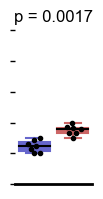

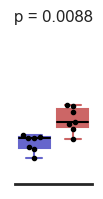

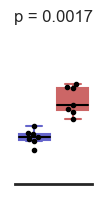

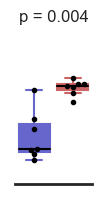

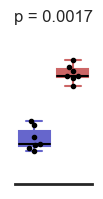

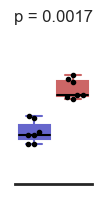

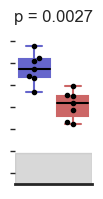

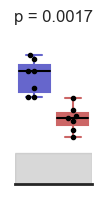

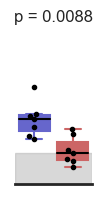

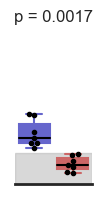

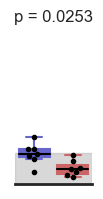

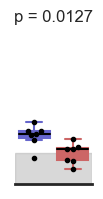

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from matplotlib.patches import Rectangle
from tifffile import imread
from os.path import exists
import pandas as pd
import seaborn as sb
from scipy.stats import ranksums

# Load data.
data_path = "G:/Shared drives/Mapping through skull/"

exp_info = {
            "DR_ctb01": {"exp_name": "20220603_101509", "rearing": "DR"}, 
            "DR_ctb02": {"exp_name": "20220610_105811", "rearing": "DR"},
            "DR_ctb07": {"exp_name": "20220711_135556", "rearing": "DR"},
            "DR_ctb08": {"exp_name": "20220715_121356", "rearing": "DR"},
            "DR_lt168": {"exp_name": "20220330_130327", "rearing": "DR"},
            "DR_lt169": {"exp_name": "20220420_125809", "rearing": "DR"},
            "DR_lt170": {"exp_name": "20220421_133932", "rearing": "DR"},
            "NR_ctb03": {"exp_name": "20220623_161247", "rearing": "NR"},
            "NR_ctb04": {"exp_name": "20220630_130119", "rearing": "NR"},
            "NR_ctb05": {"exp_name": "20220706_105937", "rearing": "NR"},
            "NR_ctb09": {"exp_name": "20220720_153020", "rearing": "NR"},
            "NR_lt171": {"exp_name": "20220427_115917", "rearing": "NR"},
            "NR_lt172": {"exp_name": "20220428_130342", "rearing": "NR"},
            "NR_lt175": {"exp_name": "20220512_124014", "rearing": "NR"}
            }

# Choose visual areas for segmentation.
area_list = ["V1", "LM", "AL", "RL", "AM", "PM"]

for ID,data in exp_info.items():
    # Load reference frame and sign map for segmenting
    exp_path = data_path + ID + "/"
    data["signmap"] = np.loadtxt(exp_path + "signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    data["area_coords"] = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        data["area_coords"][area] = np.loadtxt(exp_path + "{ar}.csv".format(ar=area))
    # Also load average magnitude, azimuth, and elevation data for downstream analyses.
    data["avg_mag"] = np.loadtxt(exp_path + "avg_mag.csv")*100
    data["azimuth"] = np.loadtxt(exp_path + "azimuth.csv")
    data["elevation"] = np.loadtxt(exp_path + "elevation.csv")
    
exp_stats = pd.DataFrame(columns=["ID", "rearing", "visual_area", "signmap_std", "avg_mag"])
base_mag = np.empty((0,))
for ID,data in exp_info.items():
    exp_path = data_path + ID + "/"
    # Compile full mask first, use this to establish magnitude baseline
    full_mask = np.full((512, 512), False)
    for area in area_list:
        area_mask = np.loadtxt(exp_path + "{ar}_mask.csv".format(ar=area))
        full_mask += area_mask.astype(bool)
    if "DR" in ID:
        base_mag = np.concatenate((base_mag, data["avg_mag"][full_mask == 0]))
    for area in area_list:
        if not exists(exp_path + "{ar}_mask.csv".format(ar=area)):
            area_mask = np.full((512, 512), False)
            # Find points contained in current area boundary.
            area_path = mplPath.Path(data["area_coords"][area])
            for row in range(area_mask.shape[0]):
                for col in range(area_mask.shape[1]):
                    area_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
            np.savetxt(exp_path + "{ar}_mask.csv".format(ar=area), area_mask)
        else:
            area_mask = np.loadtxt(exp_path + "{ar}_mask.csv".format(ar=area))
        # Visual field sign STD
        sm_masked = data["signmap"].copy()
        sm_masked[area_mask == 0] = np.nan
        signmap_std = np.nanstd(sm_masked)
        # Average magnitude
        avg_mag = np.nanmean(data["avg_mag"][area_mask == 1])
        # Write to dataframe.
        exp_stats.loc[len(exp_stats.index)] = [ID, data["rearing"], area, signmap_std, avg_mag]
        
plot_vars = ["signmap_std", "avg_mag"]
ylabs = ["Std. Dev. of Visual Field Sign", "Mean Response Magnitude ($\Delta$F/F)"]
ylims = [(0, 1),(0.25, 3.75)]
for plot_num, plot in enumerate(plot_vars):
    for area in area_list:
        fig, ax = plt.subplots()
        bx = sb.boxplot(
                        ax=ax,
                        data=exp_stats[exp_stats["visual_area"] == area], 
                        x="rearing", 
                        y=plot,
                        order=["NR", "DR"],
                        palette={"NR":(0.4, 0.4, 0.8), "DR":(0.8, 0.4, 0.4)},
                        saturation=1,
                        fliersize=0, 
                        orient="v", 
                        )
        NR_df = exp_stats[(exp_stats["visual_area"] == area) & (exp_stats["rearing"] == "NR")]
        DR_df = exp_stats[(exp_stats["visual_area"] == area) & (exp_stats["rearing"] == "DR")]
        NR_arr = np.array(NR_df[[plot]].values)
        DR_arr = np.array(DR_df[[plot]].values)
        _, pval = ranksums(NR_arr, DR_arr)
        if plot == "avg_mag":
            l_quar = np.percentile(base_mag, 5)
            u_quar = np.percentile(base_mag, 95)
            xy = (-0.5, l_quar)
            width = 2
            height = u_quar - l_quar
            rect = Rectangle(xy, width, height, facecolor=[0.7, 0.7, 0.7, 0.5], edgecolor=[0.7, 0.7, 0.7, 0.5], zorder=-1)
            bx.add_patch(rect)
        box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
        for patch_num, patch in enumerate(box_patches):
            face_color = patch.get_facecolor()
            patch.set_edgecolor(face_color)
            for line_idx, line_num in enumerate(range(patch_num*6, patch_num*6+6)):
                line = ax.lines[line_num]
                if line_idx == 4:
                    prev_color = face_color
                    face_color = "k"
                elif line_idx > 4:
                    face_color = prev_color
                line.set_color(face_color)
                line.set_mfc(face_color)
                line.set_mec(face_color)
        sb.swarmplot(
                     ax=ax,
                     data=exp_stats[exp_stats["visual_area"] == area], 
                     x="rearing", 
                     y=plot, 
                     order=["NR", "DR"], 
                     dodge=True,
                     size=3,
                     linewidth=1,
                     color="k",
                     orient="v"
                    )
        bx.set_xlabel("")
        bx.set_xticklabels([])
        bx.set_xticks([])
        if area == "V1":
            bx.set_ylabel(ylabs[plot_num], fontsize=13)
            if plot_num == 1:
                bx.set_yticks(np.arange(0.5, 4, 0.5))
            else:
                bx.set_yticks(np.arange(0, 1.2, 0.2))
        else:
            bx.set_yticks([])
        bx.set_yticklabels([])
        bx.set_ylabel("")
        bx.set_title("p = " + str(np.around(pval[0], decimals=4)))
        ax.spines["left"].set_color((1,1,1,0))
        ax.spines["right"].set_color((1,1,1,0))
        ax.spines["top"].set_color((1,1,1,0))
        ax.spines["bottom"].set_linewidth(2)
        bx.set(ylim=ylims[plot_num])
        bx.tick_params(labelsize=13, width=1)
        sb.set_style("ticks")
        fig.set_size_inches(1, 2)
        fig.savefig(data_path + area + "_" + plot + ".png", dpi=500, bbox_inches="tight")

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

areas = ["LM"] * 14 + ["RL"] * 15 + ["AM/PM"] * 20
rearing = ["NR"] * 6 + ["DR"] * 8 + ["NR"] * 7 + ["DR"] * 8 + ["NR"] * 10 + ["DR"] * 10
counts = [51, 66, 64, 68, 72, 
          1, 8, 6, 5, 8, 5, 10, 19, 
          11, 30, 20, 18, 23, 12, 16, 
          4, 7, 6, 3, 0, 1, 2, 1, 
          27, 9, 21, 15, 4, 16, 3, 1, 32, 36, 
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

pd.DataFrame()

# fig, ax = plt.subplots()
# bx = sb.boxplot(
#                 ax=ax,
#                 data=exp_stats[exp_stats["visual_area"] == area], 
#                 x="rearing", 
#                 y=plot,
#                 order=["NR", "DR"],
#                 palette={"NR":(0.4, 0.4, 0.8), "DR":(0.8, 0.4, 0.4)},
#                 saturation=1,
#                 fliersize=0, 
#                 orient="v", 
#                 )
# box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
# for patch_num, patch in enumerate(box_patches):
#     face_color = patch.get_facecolor()
#     patch.set_edgecolor(face_color)
#     for line_idx, line_num in enumerate(range(patch_num*6, patch_num*6+6)):
#         line = ax.lines[line_num]
#         if line_idx == 4:
#             prev_color = face_color
#             face_color = "k"
#         elif line_idx > 4:
#             face_color = prev_color
#         line.set_color(face_color)
#         line.set_mfc(face_color)
#         line.set_mec(face_color)
# sb.swarmplot(
#                 ax=ax,
#                 data=exp_stats[exp_stats["visual_area"] == area], 
#                 x="rearing", 
#                 y=plot, 
#                 order=["NR", "DR"], 
#                 dodge=True,
#                 size=3,
#                 linewidth=1,
#                 color="k",
#                 orient="v"
#             )

['LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'LM',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL',
 'RL']

Plot Phase Histograms

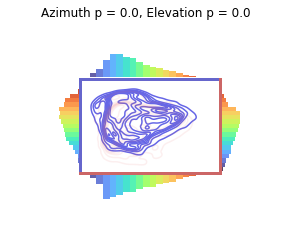

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.path as mplPath
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from os.path import exists
import pandas as pd
import seaborn as sb
from scipy.stats import ks_2samp

# Load data.
data_path = "/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Mapping_Through_Skull/"

exp_info = {
            "ctb01": {"exp_name": "20220603_101509", "rearing": "DR"}, 
            "ctb02": {"exp_name": "20220610_105811", "rearing": "DR"},
            "ctb07": {"exp_name": "20220711_135556", "rearing": "DR"},
            "ctb08": {"exp_name": "20220715_121356", "rearing": "DR"},
            "lt168": {"exp_name": "20220330_130327", "rearing": "DR"},
            "lt169": {"exp_name": "20220420_125809", "rearing": "DR"},
            "lt170": {"exp_name": "20220421_133932", "rearing": "DR"},
            "ctb03": {"exp_name": "20220623_161247", "rearing": "NR"},
            "ctb04": {"exp_name": "20220630_130119", "rearing": "NR"},
            "ctb05": {"exp_name": "20220706_105937", "rearing": "NR"},
            "ctb09": {"exp_name": "20220720_153020", "rearing": "NR"},
            "lt171": {"exp_name": "20220427_115917", "rearing": "NR"},
            "lt172": {"exp_name": "20220428_130342", "rearing": "NR"},
            "lt175": {"exp_name": "20220512_124014", "rearing": "NR"}
            }

# Choose visual areas for segmentation.
area_list = ["V1"] # , "LM", "AL", "RL", "AM", "PM"

for ID,data in exp_info.items():
    # Load reference frame and sign map for segmenting
    exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
    data["signmap"] = np.loadtxt(exp_path + "signmap.csv")
    # Create dictionary for storing visual area boundary coordinates.
    data["area_coords"] = dict(zip(area_list, [None]*len(area_list)))
    for area_num,area in enumerate(area_list):
        data["area_coords"][area] = np.loadtxt(exp_path + "{ar}.csv".format(ar=area))
    # Also load average magnitude, azimuth, and elevation data for downstream analyses.
    data["avg_mag"] = np.loadtxt(exp_path + "avg_mag.csv")*100
    data["azimuth"] = np.loadtxt(exp_path + "azimuth.csv")
    data["elevation"] = np.loadtxt(exp_path + "elevation.csv")
    
def draw_hist(ax, data, cmap, a_range, hist_mult=1, ori="vertical", side="top", color="k"):
    start, stop, step = a_range
    hist_bins = np.arange(start/stop, stop/stop, step/stop)
    colors = cmap(hist_bins)
    hist, bin_edges = np.histogram(data, np.arange(start, stop, step))
    norm_hist = hist/np.sum(hist)
    if ori == "vertical":
        ax.bar(bin_edges[:-1], hist_mult*norm_hist, color=colors, alpha=0.8, width=step)
        ax.set_xlim((start-(step/2)-2.88, stop+(step/2)+2.88))
        if hist_mult >= 0:
            ax.set_ylim([-0.01, 0.25*hist_mult])
        else:
            ax.set_ylim([0.25*hist_mult, 0.01])
    else:
        ax.barh(bin_edges[:-1], hist_mult*norm_hist, color=colors, alpha=0.8, height=step)
        ax.set_ylim((start-(step/2)-2, stop+(step/2)+2))
        if hist_mult >= 0:
            ax.set_xlim([-0.01, 0.36*hist_mult])
        else:
            ax.set_xlim([0.36*hist_mult, 0.01])
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])
    for plot_side in ["top", "bottom", "left", "right"]:
        if plot_side == side:
            ax.spines[plot_side].set_color(color)
            ax.spines[plot_side].set_linewidth(3)
        else:
            ax.spines[plot_side].set_color((1,1,1,0))

exp_stats = pd.DataFrame(columns=["ID", "rearing", "visual_area", "azimuth", "elevation"])

%matplotlib inline
for area in area_list:
    az = {"NR":[], "DR":[]}
    el = {"NR":[], "DR":[]}
    for ID,data in exp_info.items():
        exp_path = data_path + "{a}//{e}//".format(a=ID, e=data["exp_name"])
        if not exists(exp_path + "{ar}_mask.csv".format(ar=area)):
            area_mask = np.full((512, 512), False)
            # Find points contained in current area boundary.
            area_path = mplPath.Path(data["area_coords"][area])
            for row in range(area_mask.shape[0]):
                for col in range(area_mask.shape[1]):
                    area_mask[row, col] = area_path.contains_point([col, row], radius=0.001) or area_path.contains_point([col, row], radius=-0.001)
            np.savetxt(exp_path + "{ar}_mask.csv".format(ar=area), area_mask)
        else:
            area_mask = np.loadtxt(exp_path + "{ar}_mask.csv".format(ar=area))
        # Get phase values in visual area.
        curr_az = 144. - data["azimuth"][area_mask == 1]
        curr_el = data["elevation"][area_mask == 1]
        # Write to dataframe.
        az[data["rearing"]] += list(curr_az)
        el[data["rearing"]] += list(curr_el)
    labels = ["NR"] * len(az["NR"]) + ["DR"] * len(az["DR"])
    df_data = {"rearing":labels, "az":np.array(az["NR"] + az["DR"]), "el":np.array(el["NR"] + el["DR"])}
    df = pd.DataFrame(data=df_data)
    fig, ax = plt.subplots()
    dists = inset_axes(ax, width="50%", height="50%", loc="center", borderpad=0)
    sb.kdeplot(data=df, 
               x="az", 
               y="el", 
               hue="rearing", 
               fill=False, 
               ax=dists, 
               legend=False, 
               palette={"NR":(0.4, 0.4, 0.9, 1), "DR":(0.9, 0.4, 0.4, 0.1)},)
               # alpha=0.8)
    dists.axis("off")
    dists.set_xlim([-6.63, 150.63])
    dists.set_ylim([-4.5, 104.5])
    el_NR = inset_axes(ax, width="25%", height="50%", loc="center left", borderpad=0)
    draw_hist(el_NR, el["NR"], plt.cm.turbo, (0., 100., 5), hist_mult=-1, ori="horizontal", side="right", color=(0.4, 0.4, 0.8))
    az_NR = inset_axes(ax, width="50%", height="25%", loc="upper center", borderpad=0)
    draw_hist(az_NR, az["NR"], plt.cm.turbo, (0., 144., 7.5), side="bottom", color=(0.4, 0.4, 0.8))
    el_DR = inset_axes(ax, width="25%", height="50%", loc="center right", borderpad=0)
    draw_hist(el_DR, el["DR"], plt.cm.turbo, (0., 100., 5), ori="horizontal", side="left", color=(0.8, 0.4, 0.4))
    az_DR = inset_axes(ax, width="50%", height="25%", loc="lower center", borderpad=0)
    draw_hist(az_DR, az["DR"], plt.cm.turbo, (0., 144., 7.5), hist_mult=-1, side="top", color=(0.8, 0.4, 0.4))
    _, pval_az = ks_2samp(az["NR"], az["DR"])
    _, pval_el = ks_2samp(el["NR"], el["DR"])
    fig.suptitle("Azimuth p = {0}, Elevation p = {1}".format(np.around(pval_az, decimals=4), np.around(pval_el, decimals=4)))
    ax.remove()
    fig.set_size_inches(5, 3.47)
    # fig.savefig(data_path + area + "_dists.png", dpi=500)